import packages and libraries

In [1]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
import os
import pickle

feed the dataset and shuffle it.

In [2]:
from sklearn.utils import shuffle

file_path = '../Sup/datset_fin.csv'
dataset = pd.read_csv(file_path,header=None)
dataset = shuffle(dataset)
dataset.head()

,0,1,2
371,Such a disappointment of acting.,CAST#PERFORMANCE,Negative
716,don't get mistaken by this one star. the movi...,CAST#PERFORMANCE,Positive
144,In a bad director's hand this have been divas...,DIRECTING#PERFORMANCE,Negative
145,Such a disappointment of film making.,DIRECTING#PERFORMANCE,Negative
779,todd phillips directed this movie with pure p...,DIRECTING#PERFORMANCE,Positive


brief inspection of the dataset

In [3]:
data = dataset[0]
data.head()

371                     Such a disappointment of acting.
716    don't get mistaken by this one star.  the movi...
144     In a bad director's hand this have been divas...
145                Such a disappointment of film making.
779     todd phillips directed this movie with pure p...
Name: 0, dtype: object

In [4]:
label_pol = dataset[2]
label_pol.unique()

array(['Negative', 'Positive'], dtype=object)

start the nlp pipeline

In [5]:
import spacy
nlp = spacy.load('en_core_web_sm')

preprocess the dataset.

In [6]:
sentiment_terms = []
for review in nlp.pipe(data):
        if review.is_parsed:
            sentiment_terms.append(' '.join([token.lemma_ for token in review if (not token.is_stop and not token.is_punct and (token.pos_ == "ADJ" or token.pos_ == "VERB"))]))
        else:
            sentiment_terms.append('')
dataset[4] = sentiment_terms
#dataset.head(10)

define the model

In [16]:
model = Sequential()
model.add(Dense(512, input_shape=(6000,), activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

label encode the features

In [17]:
from keras.preprocessing.text import Tokenizer

vocab_size = 6000 # We set a maximum size for the vocabulary
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data)
aspect_tokenized = pd.DataFrame(tokenizer.texts_to_matrix(dataset[4]))

# seperete train and test set 900<- train set, 100<- test set
aspect_tokeniz = aspect_tokenized.iloc[:900,:]
test_x = aspect_tokenized.iloc[900:,:]

In [18]:
lbl_encoder = LabelEncoder()
dataset[5] = label_pol.apply(lambda x:1 if x == 'Positive' else 0)

dataset.head(15)

,0,1,2,4,5
371,Such a disappointment of acting.,CAST#PERFORMANCE,Negative,,0
716,don't get mistaken by this one star. the movi...,CAST#PERFORMANCE,Positive,mistake great love credit good middle add diff...,1
144,In a bad director's hand this have been divas...,DIRECTING#PERFORMANCE,Negative,bad divastate,0
145,Such a disappointment of film making.,DIRECTING#PERFORMANCE,Negative,,0
779,todd phillips directed this movie with pure p...,DIRECTING#PERFORMANCE,Positive,direct pure show care,1
838,todd phillips does an incredible job at makin...,DIRECTING#PERFORMANCE,Positive,incredible make feel uncomfortable,1
512,actor joaquin phoenix should be given oscar aw...,CAST#PERFORMANCE,Positive,give laugh.the good watch,1
1313,This performance is absolutely horrific.,CAST#PERFORMANCE,Negative,horrific,0
804,i'm satisfied with the direction,DIRECTING#PERFORMANCE,Positive,satisfied,1
1239,untalented DIRECTOR,DIRECTING#PERFORMANCE,Negative,,0


split the dataset between train and test

In [19]:
import numpy as np
y = np.array(dataset[5])
train_y = y[:900]
test_y = y[900:]

define visualization function

In [20]:
import matplotlib.pylab as plt

def plot_var(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc , label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

train the model

0 2001
47 1987
Train on 900 samples, validate on 853 samples
Epoch 1/5
900/900 [==============================] - 1s 731us/sample - loss: 0.6496 - accuracy: 0.6233 - val_loss: 0.5187 - val_accuracy: 0.8734
Epoch 2/5
900/900 [==============================] - 0s 249us/sample - loss: 0.4280 - accuracy: 0.8533 - val_loss: 0.2806 - val_accuracy: 0.8910
Epoch 3/5
900/900 [==============================] - 0s 241us/sample - loss: 0.2635 - accuracy: 0.8789 - val_loss: 0.2258 - val_accuracy: 0.9050

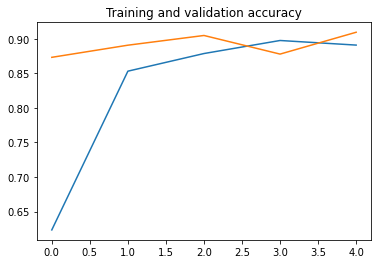

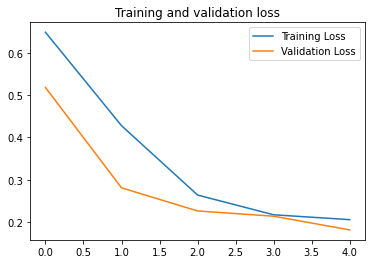

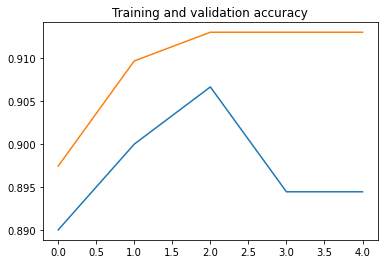

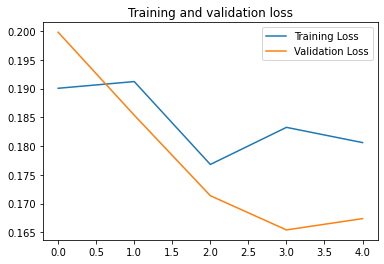

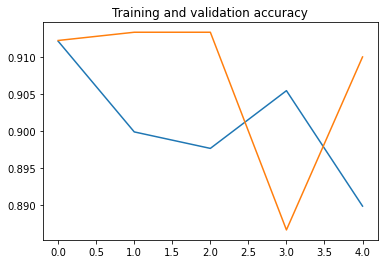

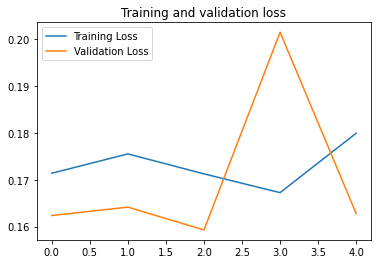

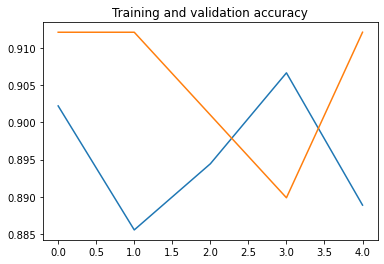

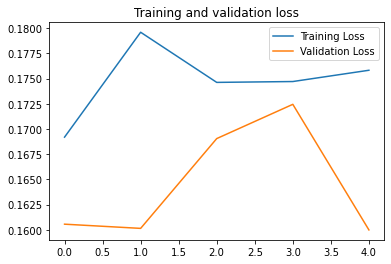

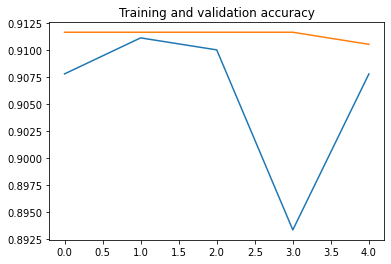

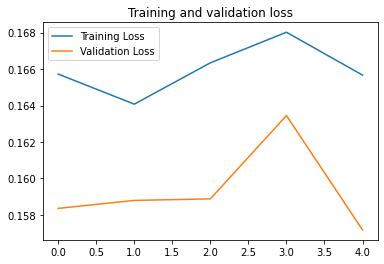

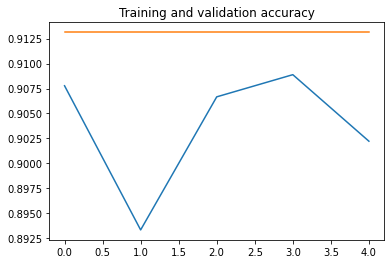

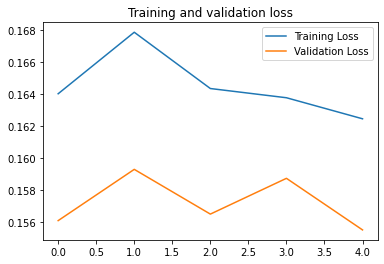

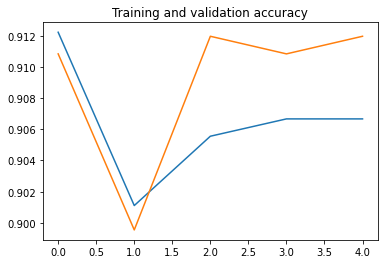

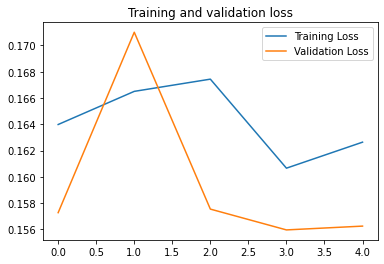

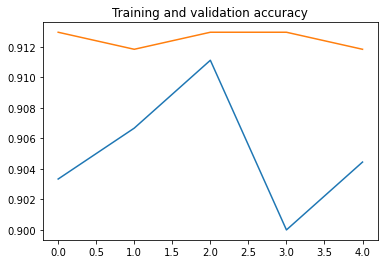

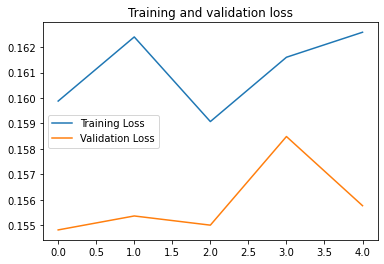

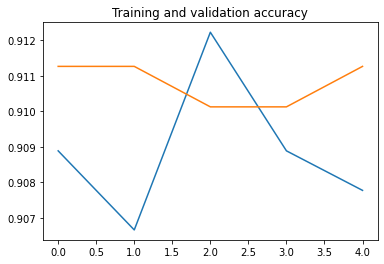

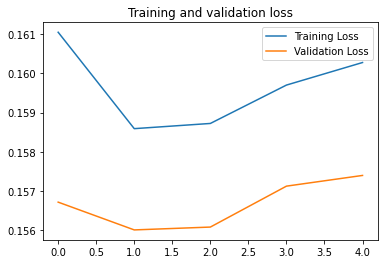

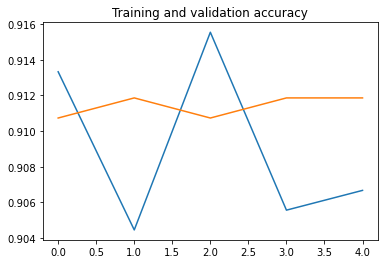

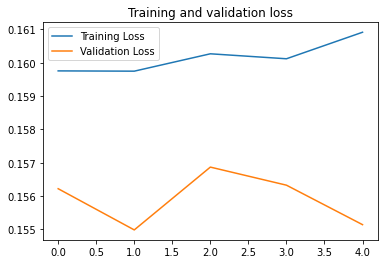

In [21]:
from sklearn.model_selection import KFold

cv = KFold(10,shuffle=True,random_state=1)
for train_ind,test_ind in cv.split(aspect_tokenized):
    print(train_ind[0],train_ind[-1])
    print(test_ind[0],test_ind[-1])
    train_start,train_end,test_start,test_end = train_ind[0],train_ind[-1],test_ind[0],test_ind[-1]
    X_train, X_test, y_train, y_test = aspect_tokeniz.loc[train_start:train_end,:],\
                                       aspect_tokeniz.loc[test_start:test_end,:], \
                                       train_y[train_start:train_end], \
                                       train_y[test_start:test_end]
    history = model.fit(X_train,y_train,epochs=5,verbose=1,validation_data=(X_test,y_test))
    plot_var(history)

model saving

In [22]:
model_save_path = '../Sup'
weight_save_path = '../Sup'
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)
if not os.path.exists(weight_save_path):
    os.mkdir(weight_save_path)
model.save( '../Sup/sentimental_model.h5')
model.save_weights( "../Sup/sentimental_model_weights.h5")

In [14]:
# saving
#if not os.path.exists('../Sup/tokenizer.pickle'):
#    os.mkdir('../Sup/tokenizer.pickle')
with open('../Sup/sentimental_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
#with open('../Sup/sentimental_labeleEncorder.pkl', 'wb') as handle:
#   pickle.dump(lbl_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

evaluate on test set

In [23]:
from keras import metrics
logs = model.evaluate(test_x,test_y)
print(logs)
#predictions = model.predict(test_x)

#acc = metrics.confusion_matrix(y_test,predictions)
#print(acc)

1102/1102 [==============================] - 0s 100us/sample - loss: 0.9859 - accuracy: 0.7332
[0.9858939801283627, 0.73321235]
